# The statistics of being ticketed for parking too long 
### How safe is it to park for various lengths over the time limit?
I often park on a street with free parking but a 2-hour time limit and then lock the car and walk away. I have tended to be very careful to come retrieve the car by exactly the 2-hour mark. But I have recently realized, thanks to a conversation with a friend, that the odds of getting a ticket even just a few minutes outside the 2 hour window are nearly zero. In this notebook, I'm interested in modeling just how risky it is to park over the time limit by various amounts, and how this depends on the behavior of the parking enforcement professionals. 

In order for you to get a ticket after you leave your car, two events need to occur, in this sequences: 
1. An parking-rule enforcement person arrives (and records that your car is there). 
* They arrive again, at least 2-hours after their first arrival, at which time they can give the ticket.  



In [14]:
import numpy as np
import scipy 
import pandas as pd 
import matplotlib as mpl
from scipy.stats import uniform, expon, gamma

from matplotlib.ticker import FuncFormatter
%matplotlib inline
mpl.rcParams.update({'font.size': 13})


## The broadest model
No matter what pattern the enforcers are using to traverse the streets, the first arrival will be totally uncorrelated with when you park. Thus it seems fair to let this first random component, T1, be drawn from a [negative exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution): 

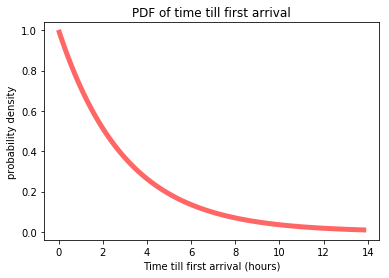

In [2]:
from scipy.stats import expon
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
x = np.linspace(expon.ppf(0.01),
                expon.ppf(0.99), 100)
ax.set_ylabel('probability density')
ax.set_xlabel('Time till first arrival (hours)')
ax.set_title('PDF of time till first arrival')
ax.plot(3*x, expon.pdf(x),
       'r-', lw=5, alpha=0.6, label='expon pdf')

I've decided to model the PDF of the time between arrivals of the enforcer with the gamma function. 

Here, the PDF mean corresponds to mean time between visits; the variance, $\sigma^2$, of the PDF corresponds to how imprecise the periodicity of the visits is. 

When $\sigma$ becomes so big that it equals the mean, then scale and a both become 1, and the gamma function becomes simply a negative exponential distribution again, which is what we'd like to happen. 

Here is the Gamma distribution PDF: 
\begin{align}
\mathrm{PDF_{wikipedia}}(x) = \frac{1}{\Gamma(k)\theta^k} x^{k-1} e^{-x/\theta},
\end{align}

where $\theta$ is the mean wait time between individual *iid* (exponential distribution) events and $k$ is the total number of events. 

Meanwhile, here's the scipy form: 

\begin{align}
\mathrm{PDF_{scipy}}(x) = \frac{x^{a-1} e^{-x}}{\Gamma(a)};
\end{align}

and more specifically (according to the scipy docs): 

\begin{align}
\mathrm{PDF_{scipy}}(x, a, \mathrm{loc}, \mathrm{scale}) &= \frac{1}{\mathrm{scale}}  \frac{(\frac{(x-\mathrm{loc})}{\mathrm{scale}})^{a-1} e^{-(\frac{(x-\mathrm{loc})}{\mathrm{scale}})}}{\Gamma(a)} 
\end{align}


Comparing these two, it appears that 
\begin{align}
k &\rightarrow a\\
x_{\mathrm{wikipedia}} &\rightarrow x_{\mathrm{scipy}}-\mathrm{loc}\\
\theta &\rightarrow \mathrm{scale}.
\end{align}

I want to figure out how to substitute the scipy arguments for the equivalent wikipedia measurements of $\sigma$ and mean; comparing, I see that 

\begin{align}
\mathrm{mean} &= \theta k \\
& \rightarrow \mathrm{scale}\cdot a 
\end{align}

and 

\begin{align}
\sigma &=  \theta\sqrt{k} \\
&\rightarrow \mathrm{scale} \sqrt{a}.
\end{align}

Finally, solving these two equations for scale and $a$ we get:

\begin{align}
\mathrm{scale} = \frac{\sigma^2}{\mathrm{mean}};
\end{align}


\begin{align}
a = \big{(}\frac{\mathrm{mean}}{\sigma}\big{)}^2.
\end{align}






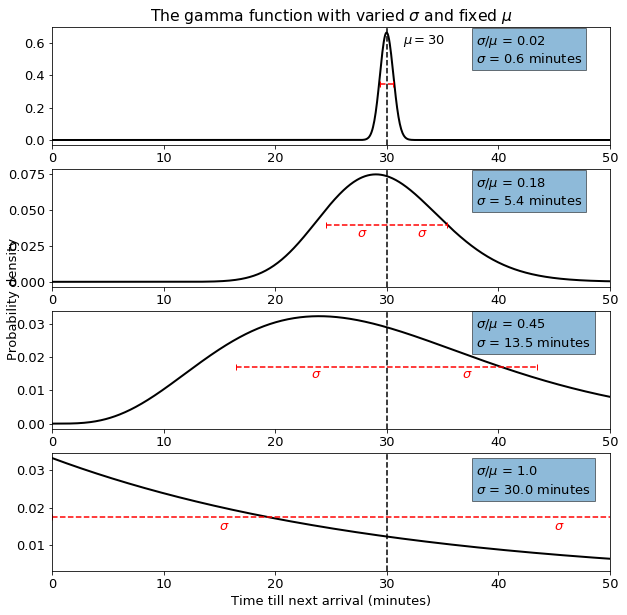

In [17]:
from scipy.stats import gamma
n_subplots = 4
sigma_over_mu =  [0.02, 0.18, 0.45, 1]
fig, ax = plt.subplots(n_subplots, 1)
fig.set_size_inches(10,10)

mean = 30.0
x = np.linspace(0, 2*mean, 1000)



for i in range(n_subplots):
    ax[i].set_xlim(0, 50)
    sigma = mean * sigma_over_mu[i]
    a = (mean/sigma)**2
    scale = sigma**2 / mean
    ax[i].plot(x, gamma.pdf(x, a=a, loc=0, scale=scale), 'k-', lw=2)
    ax[i].axvline([mean], 0, 1, linestyle='--', color='k')
    text = '$\sigma/\mu$ = {}\n'.format(sigma/mean) + '$\sigma$ = {} minutes'.format(sigma)
    ax[i].text(ax[i].get_xlim()[1] * 0.76, ax[i].get_ylim()[1] * 0.7, text,
              bbox=dict(facecolor=None, alpha=0.5))
    if i == 0:
        ax[i].text(mean * 1.05, ax[i].get_ylim()[1] * 0.85, '$\mu = 30$')
    y_sigma = ax[i].get_ylim()[1]/2
    ax[i].plot([mean-sigma, mean+sigma], [y_sigma, y_sigma],
                 linestyle='--', marker='|', color='red')
    if sigma_over_mu[i] > 0.05:
        ax[i].text(mean + sigma/2., y_sigma * 0.8,
                   '$\sigma$', color='red' )
        ax[i].text(mean - sigma/2., y_sigma * 0.8,
                   '$\sigma$', color='red' )
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('Time till next arrival (minutes)')
plt.ylabel("Probability density")
plt.title("The gamma function with varied $\sigma$ and fixed $\mu$")
plt.savefig('parking_gamma.png', bbox_inches='tight')

plt.show()


## Modeling ticket PDF with Monte Carlo

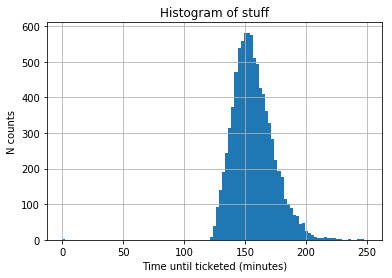

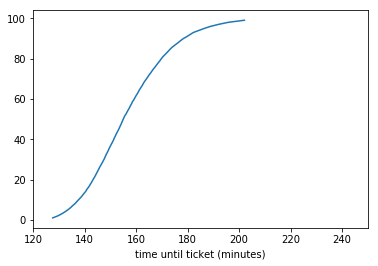

In [8]:

def make_wait_times(N, mean=30, sigma=10):
    a = (mean/sigma)**2
    scale = sigma**2 / mean
    wait_times = gamma.rvs(a=a, loc=0, scale=scale, 
                  size=[N])
    return wait_times

def make_first_wait_time(mean, sigma, N):
    sigma, mean = float(sigma), float(mean)
    periodic_contrib = (1 - sigma/mean) * uniform.rvs(loc=0, scale=mean, size=N)
    random_contrib = (sigma / mean) * make_wait_times(N, mean=mean, sigma=mean)
    return periodic_contrib + random_contrib

def generate_data(N_trials, mean=30, sigma=10, maxtime=120):
    mean = float(mean); sigma = float(sigma); maxtime = float(maxtime)
    N = int(N_trials * (maxtime/mean))
    initial_wait = make_first_wait_time(mean, sigma, N) 
    wait_times = make_wait_times(N=N, mean=mean, sigma=sigma)
    data = np.zeros([len(wait_times)])
    trial = 0
    i = 0
    elapsed_time = 0.0
    while i < N-2:
        while elapsed_time < maxtime:
            elapsed_time += wait_times[i]
            if i >= N-2:
                elapsed_time = 0.0
                break
            i += 1
        if i < N - 2:
            data[trial] = elapsed_time + initial_wait[i]
        trial += 1
        elapsed_time = 0.0
    data = data[:trial]
            
    return data
    
    
def make_histogram_all_visits(data):
    wait_times = data

    # the histogram of the data
    n, bins, patches = plt.hist(wait_times, bins=np.linspace(0,250,100),
                               cumulative=False)
    
    plt.xlabel('Time until ticketed (minutes)')
    plt.ylabel('N counts')
    plt.title('Histogram of stuff')
    plt.grid(True)
    plt.show()
        
def compute_percentiles(data):
    percentile = np.linspace(1, 99, 98)
    x = np.percentile(data, percentile, interpolation='higher')
    df = pd.DataFrame(data=zip(percentile, x - 120), columns=['percentile', 'wait time'])
    # print(df.round(0))
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('time until ticket (minutes)')
    ax.set_xlim([120,250])
    ax.plot(x, percentile)
    
data = generate_data(N_trials=10000, mean=30, sigma=10)

make_histogram_all_visits(data)
compute_percentiles(data)

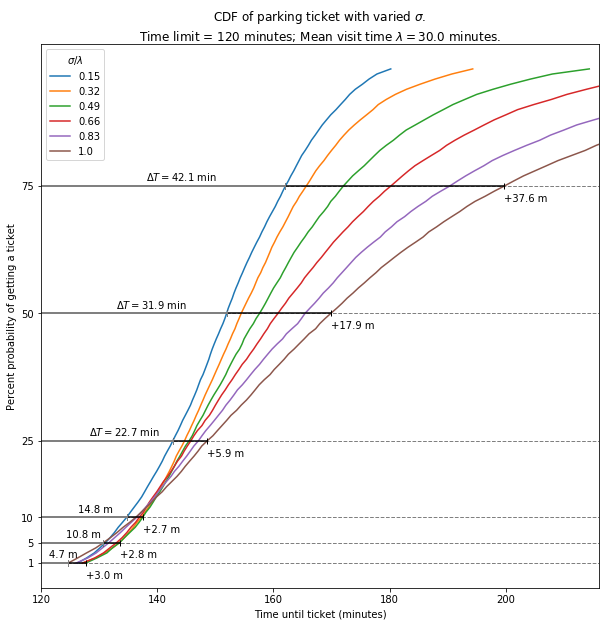

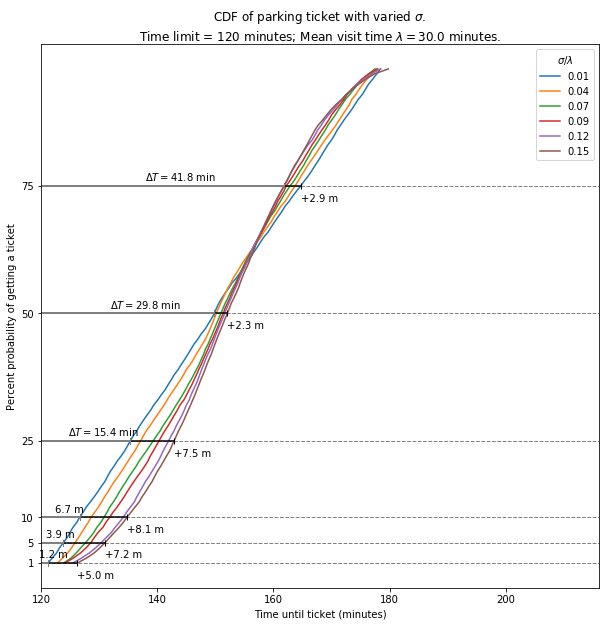

In [9]:
def plot_several_CDFs(sigmas_as_frac_mean_visit, mean_visit_as_frac_maxtime=0.25, maxtime=120, 
                      N=10000, ticks=[1, 5, 10, 25, 50, 75]):
    mean_visit = float(maxtime) * float(mean_visit_as_frac_maxtime)
    sigmas = sigmas_as_frac_mean_visit * mean_visit
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10,10)
    ax.set_xlabel('Time until ticket (minutes)')
    ax.set_xlim([maxtime, maxtime * 1.8])
    ax.set_title(
        'CDF of parking ticket with varied $\sigma$.\nTime limit = {} minutes; Mean visit time $\lambda= {}$ minutes.'.format(
            maxtime, mean_visit))
    ax.set_ylabel('Percent probability of getting a ticket')
    percentile = np.arange(1, 99)
    df = pd.DataFrame([])
    for sigma in sigmas:
        data = generate_data(N_trials=N, mean=mean_visit, 
                             sigma=sigma, maxtime=maxtime)
        x = np.percentile(data, percentile, interpolation='higher')
        df['{}'.format(sigma)] = x
        ax.plot(x, percentile, label='{}'.format(round(sigma/mean_visit, 2)))
    ax.legend(title='$\sigma/\lambda$')
    for percentile in ticks:
        i = percentile - 1
        xleft = df.iloc[i].min(axis=0)
        xright = df.iloc[i].max(axis=0)
        
        # horizontal bar across lines.
        ax.plot([xleft, xright],
                [percentile, percentile], marker='|', color='k')
        ax.plot([2, xleft ],
                [percentile, percentile], marker='|', color='gray',
               linewidth=2)
        deltaT = xleft - maxtime
        if deltaT > 15.0:
            ax.text(maxtime + (xleft-maxtime)/2 - 3, 
                percentile + 1, '$\Delta T = $' + 
                    str(round(deltaT, 1)) + ' min')
        else:
            ax.text(maxtime + (deltaT)/2 - 1, 
                percentile + 1, str(round(xleft - maxtime, 1)) + ' m')
        ax.text(xright, percentile - 3, '+' + str(round(xright - maxtime - deltaT, 1)) + ' m')
    ax.set_yticks(ticks)
    ax.hlines(y=ticks, xmin=maxtime, xmax=maxtime*1.8, linestyles='dashed', 
              colors='gray', linewidth=1)
    
    
        
#plot_several_CDFs(sigmas=np.linspace(6, 30, 6), mean_visit=30, N=10000)
plot_several_CDFs(sigmas_as_frac_mean_visit=np.linspace(0.15, 1, 6), 
                  mean_visit_as_frac_maxtime=0.25, N=10000,
                 maxtime=120)
plot_several_CDFs(sigmas_as_frac_mean_visit=np.linspace(0.01, 0.15, 6), 
                  mean_visit_as_frac_maxtime=0.25, N=10000)




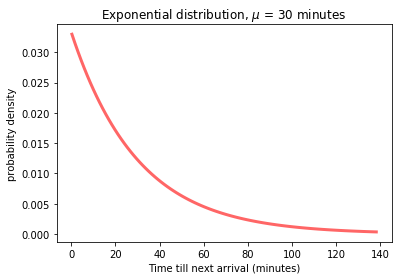

In [10]:
from scipy.stats import expon
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
scale = 30.
x = np.linspace(expon.ppf(0.01, scale=scale),
                expon.ppf(0.99, scale=scale), 100)
ax.set_ylabel('probability density')
ax.set_xlabel('Time till next arrival (minutes)')
ax.set_title('Exponential distribution, $\mu$ = 30 minutes')
ax.plot(x, expon.pdf(x, scale=scale),
       'r-', lw=3, alpha=0.6, label='expon pdf')
plt.savefig('parking_exponential.png', bbox_inches='tight')

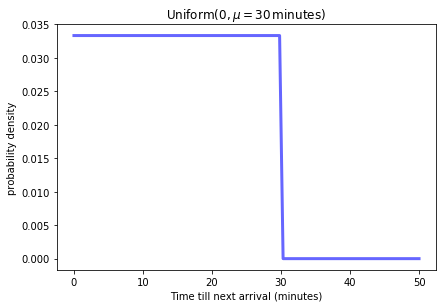

In [11]:
from scipy.stats import expon
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
#fig = plt.figure(figsize=(6, 8))
plt.tight_layout()


x = np.linspace(0, 50, 100)
ax.set_ylabel('probability density')
ax.set_xlabel('Time till next arrival (minutes)')
ax.set_title('$\mathrm{Uniform}(0, \mu = 30 \,\mathrm{minutes}$)')
ax.plot(x, uniform.pdf(x, scale=scale),
       'b-', lw=3, alpha=0.6, label='expon pdf')
plt.savefig('parking_uniform.png', bbox_inches='tight')

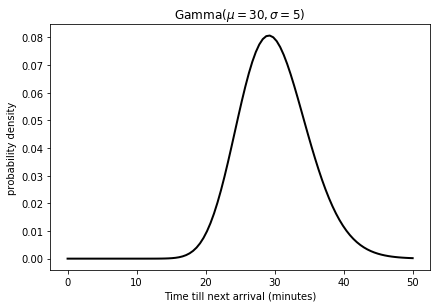

In [12]:
from scipy.stats import gamma
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
plt.tight_layout()

mean = 30.0
sigma = 5
x = np.linspace(0, 2*mean, 1000)


x = np.linspace(0, 50, 100)
ax.set_ylabel('probability density')
ax.set_xlabel('Time till next arrival (minutes)')
ax.set_title('$\mathrm{Gamma}(\mu = 30, \sigma=5$)')

a = (mean/sigma)**2
scale = sigma**2 / mean
ax.plot(x, gamma.pdf(x, a=a, loc=0, scale=scale), 'k-', lw=2)

plt.savefig('parking_gamma_single.png', bbox_inches='tight')
plt.show()